#Import the Libraries and load dataset

In [1]:
import numpy as np
import pandas as pd 
import re
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Attention
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data=pd.read_csv("/content/drive/MyDrive/CSCE 5290 - NLP/Reviews.csv",nrows=100000)

In [4]:
# Drop duplicates and NA
data.drop_duplicates(subset=['Text'],inplace=True)#dropping duplicates
data.dropna(axis=0,inplace=True)#dropping na

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88421 entries, 0 to 99999
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Id                      88421 non-null  int64 
 1   ProductId               88421 non-null  object
 2   UserId                  88421 non-null  object
 3   ProfileName             88421 non-null  object
 4   HelpfulnessNumerator    88421 non-null  int64 
 5   HelpfulnessDenominator  88421 non-null  int64 
 6   Score                   88421 non-null  int64 
 7   Time                    88421 non-null  int64 
 8   Summary                 88421 non-null  object
 9   Text                    88421 non-null  object
dtypes: int64(5), object(5)
memory usage: 7.4+ MB


#Preprocessing


In [6]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

In [7]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


**Text cleaning:**

1.Convert to lowercase

2.Remove HTML

3.Replace contractions

5.Remove text inside parenthesis

6.Remove punctuations and special characters

7.Remove stopwords

8.Remove short words

In [8]:
stop_words = set(stopwords.words('english')) 

def text_cleaner(text,num):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    newString = re.sub('[m]{2,}', 'mm', newString)
    if(num==0):
        tokens = [w for w in newString.split() if not w in stop_words]
    else:
        tokens=newString.split()
    long_words=[]
    for i in tokens:
        if len(i)>1:                                                 #removing short word
            long_words.append(i)   
    return (" ".join(long_words)).strip()

In [9]:
#call the function for reviews
cleaned_text = []
for t in data['Text']:
    cleaned_text.append(text_cleaner(t,0)) 

In [10]:
cleaned_text[:5]  

['bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better',
 'product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo',
 'confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch',
 'looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal',
 'great taffy great price wide assortment yummy taffy delivery quick taffy lover deal']

In [11]:
#call the function for summaries
cleaned_summary = []
for t in data['Summary']:
    cleaned_summary.append(text_cleaner(t,1))

In [12]:
cleaned_summary[:10]

['good quality dog food',
 'not as advertised',
 'delight says it all',
 'cough medicine',
 'great taffy',
 'nice taffy',
 'great just as good as the expensive brands',
 'wonderful tasty taffy',
 'yay barley',
 'healthy dog food']

In [13]:
data['cleaned_text']=cleaned_text
data['cleaned_summary']=cleaned_summary

In [14]:
# Drop empty rows, if any
data.replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)

#Understanding the distribution of the sequences


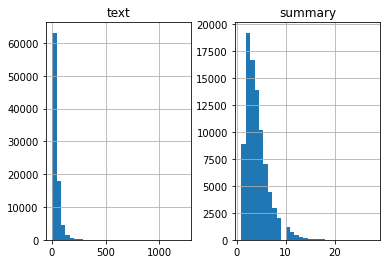

In [15]:
import matplotlib.pyplot as plt

text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in data['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in data['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})

length_df.hist(bins = 30)
plt.show()

In [17]:
# Check % of word bellow threshold (in this case 8)
thresh = 8
cnt=0
for i in data['cleaned_summary']:
    if len(i.split()) <= thresh:
        cnt=cnt+1
print(cnt/len(data['cleaned_summary']))

0.9424907471335922


In [18]:
# Set review and summary max lengths
max_text_len=30
max_summary_len=8

In [19]:
cleaned_text = np.array(data['cleaned_text'])
cleaned_summary = np.array(data['cleaned_summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
        
df = pd.DataFrame({'text':short_text,'summary':short_summary})

In [20]:
# Add <sos> and <eos> tokens
df['summary'] = df['summary'].apply(lambda x : 'sostok '+ x + ' eostok')

In [21]:
df['summary'][1]

'sostok not as advertised eostok'

# Splitting the dataset in 80% train, 10% validation and 10% test sets

In [22]:
from sklearn.model_selection import train_test_split
x_tr,x_test,y_tr,y_test=train_test_split(np.array(df['text']),np.array(df['summary']),test_size=0.1,random_state=0,shuffle=True) 

In [23]:
x_tr,x_val,y_tr,y_val=train_test_split(x_tr,y_tr,test_size=0.1,random_state=0,shuffle=True) 

#Preparing the Tokenizer

**Text Tokenizer**

In [28]:
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences

#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))

**Check for rarewords (threshold = 4)**


In [29]:
thresh=4

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 66.10591112235433
Total Coverage of rare words: 3.1257069330954916


In [30]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)
x_test_seq   =   x_tokenizer.texts_to_sequences(x_test)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')
x_test   =   pad_sequences(x_test_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1

In [31]:
x_voc

8040

**Summary Tokenizer**

In [32]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))

**Check for rarewords (threshold = 6)**

In [33]:
thresh=6

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 78.40975043528728
Total Coverage of rare words: 5.679866602763799


In [34]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val)
y_test_seq   =   y_tokenizer.texts_to_sequences(y_test)  

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')
y_test   =   pad_sequences(y_test_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1

In [35]:
# Double check if all sentences have eos token
y_tokenizer.word_counts['eostok'],len(y_tr)   

(38207, 38207)

In [36]:
# Delete empty sentences
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

In [37]:
ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

In [38]:
ind=[]
for i in range(len(y_test)):
    cnt=0
    for j in y_test[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_test=np.delete(y_test,ind, axis=0)
x_test=np.delete(x_test,ind, axis=0)

# First Model: LSTM

In [39]:
from keras import backend as K 
K.clear_session()

latent_dim = 300
embedding_dim=100

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary() 

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 30)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 30, 100)      804000      ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 30, 300),    481200      ['embedding[0][0]']              
                                 (None, 300),                                                     
                                 (None, 300)]                                                     
                                                                                              

In [40]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [41]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)

In [42]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=10,callbacks=[es],batch_size=128, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Epoch 1/10
291/291 [==============================] - 150s 473ms/step - loss: 2.8468 - val_loss: 2.5315
Epoch 2/10
291/291 [==============================] - 137s 470ms/step - loss: 2.5523 - val_loss: 2.4061
Epoch 3/10
291/291 [==============================] - 136s 468ms/step - loss: 2.4318 - val_loss: 2.3121
Epoch 4/10
291/291 [==============================] - 136s 468ms/step - loss: 2.3328 - val_loss: 2.2458
Epoch 5/10
291/291 [==============================] - 136s 468ms/step - loss: 2.2544 - val_loss: 2.1717
Epoch 6/10
291/291 [==============================] - 137s 469ms/step - loss: 2.1900 - val_loss: 2.1409
Epoch 7/10
291/291 [==============================] - 136s 468ms/step - loss: 2.1401 - val_loss: 2.0999
Epoch 8/10
291/291 [==============================] - 137s 470ms/step - loss: 2.0977 - val_loss: 2.0901
Epoch 9/10
291/291 [==============================] - 136s 468ms/step - loss: 2.0604 - val_loss: 2.0599
Epoch 10/10
291/291 [==============================] - 136s 467m

**Diagnostic plot**

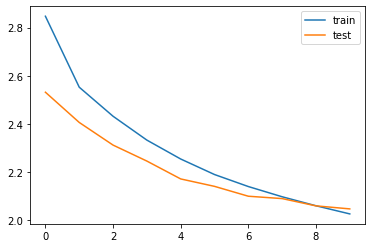

In [43]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [44]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

**Inference for LSTM model**

In [45]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']
    
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        
        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [46]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [47]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
#attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
#decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
#decoder_outputs2 = decoder_dense(decoder_inf_concat) 
decoder_outputs2 = decoder_dense(decoder_outputs2) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

**Testing the model**:

In [48]:
for i in range(10):
    print("Review:",seq2text(x_test[i]))
    print("Original summary:",seq2summary(y_test[i]))
    print("Predicted summary:",decode_sequence(x_test[i].reshape(1,max_text_len)))
    #print("\n")

Review: great healthy chew old beagle rio loves taste sure beats arm 
Original summary: yummy 
Predicted summary:  great for training
Review: thank goodness carbonated drink tasty without additives taste like cherry drinks slightly lighter flavoring although less half volume normal wonder things good comes small size least recycled 
Original summary: it is tasty 
Predicted summary:  great taste
Review: extra bold coffee one favorites extra bold could compared bold coffee regular coffee brewer 
Original summary: great coffee for keurig brewer 
Predicted summary:  great coffee
Review: like flavored coffee taste like coffee may could taste coffee travel size brew smaller brew sizes bit better 
Original summary: too much caramel cream not enough coffee 
Predicted summary:  good coffee
Review: slightly overpriced one kitty last month less pound bags recently purchased petsmart dollars pound bag 
Original summary: great food 
Predicted summary:  good product
Review: boss likes smarties saw g

In [49]:
# Save results in a dataframe for analysis
original = []
predicted = []
for i in range(1000):  
  original.append(seq2summary(y_test[i]))
  predicted.append(decode_sequence(x_test[i].reshape(1,max_text_len)))

df_results_lstm = pd.DataFrame(list(zip(original, predicted)), columns =['Original', 'Predicted'])
df_results_lstm.info 

<bound method DataFrame.info of                                       Original            Predicted
0                                       yummy    great for training
1                                 it is tasty           great taste
2              great coffee for keurig brewer          great coffee
3    too much caramel cream not enough coffee           good coffee
4                                  great food          good product
..                                         ...                  ...
995                              tastes great                  good
996                                  pretzels           great snack
997                           is not half bad    good but not great
998                      very unique beverage               not bad
999               the best stuff in the world             best ever

[1000 rows x 2 columns]>

In [50]:
filename = '/content/drive/MyDrive/CSCE 5290 - NLP/CSCE 5290 - Final Project/results_lstm_final.csv'
df_results_lstm.to_csv(filename)

# Bidirectional LSTM Model

In [51]:
from tensorflow.keras.layers import Bidirectional

In [52]:
from keras import backend as K 
K.clear_session()

latent_dim = 300
embedding_dim=100

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = Bidirectional(LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4))
encoder_output1, forward_h1, forward_c1, backward_h1, backward_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = Bidirectional(LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4))
encoder_output2, forward_h2, forward_c2, backward_h2, backward_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=Bidirectional(LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4))
encoder_outputs, forward_h, forward_c, backward_h, backward_c = encoder_lstm2(encoder_output2)

state_h = Concatenate()([forward_h, backward_h])
state_c = Concatenate()([forward_c, backward_c])

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim*2, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
#decoder_outputs = decoder_dense(decoder_concat_input)
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary() 

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 30)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 30, 100)      804000      ['input_1[0][0]']                
                                                                                                  
 bidirectional (Bidirectional)  [(None, 30, 600),    962400      ['embedding[0][0]']              
                                 (None, 300),                                                     
                                 (None, 300),                                                     
                                 (None, 300),                                                 

In [53]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [54]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)

In [55]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=10,callbacks=[es],batch_size=128, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Epoch 1/10
291/291 [==============================] - 279s 896ms/step - loss: 2.8275 - val_loss: 2.5274
Epoch 2/10
291/291 [==============================] - 260s 892ms/step - loss: 2.5132 - val_loss: 2.3591
Epoch 3/10
291/291 [==============================] - 260s 893ms/step - loss: 2.3740 - val_loss: 2.2706
Epoch 4/10
291/291 [==============================] - 258s 888ms/step - loss: 2.2833 - val_loss: 2.1979
Epoch 5/10
291/291 [==============================] - 257s 882ms/step - loss: 2.2206 - val_loss: 2.1597
Epoch 6/10
291/291 [==============================] - 256s 880ms/step - loss: 2.1705 - val_loss: 2.1328
Epoch 7/10
291/291 [==============================] - 258s 885ms/step - loss: 2.1238 - val_loss: 2.1182
Epoch 8/10
291/291 [==============================] - 252s 866ms/step - loss: 2.0810 - val_loss: 2.0871
Epoch 9/10
291/291 [==============================] - 251s 864ms/step - loss: 2.0393 - val_loss: 2.0741
Epoch 10/10
291/291 [==============================] - 251s 863m

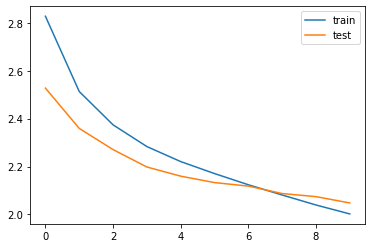

In [56]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [57]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

**Inference for LSTM Bidirectional model**

In [58]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [59]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_fh, e_fc, e_bh, e_bc = encoder_model.predict(input_seq)
    
    e_h = Concatenate()([e_fh, e_bh])
    e_c = Concatenate()([e_fc, e_bc])

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']
    
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        
        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [60]:
# Encode the input sequence to get the feature vector
#encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, forward_h, forward_c, backward_h, backward_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim*2,))
decoder_state_input_c = Input(shape=(latent_dim*2,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim*2))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
#attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
#decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
#decoder_outputs2 = decoder_dense(decoder_inf_concat) 
decoder_outputs2 = decoder_dense(decoder_outputs2) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [61]:
for i in range(10):
    print("Review:",seq2text(x_test[i]))
    print("Original summary:",seq2summary(y_test[i]))
    print("Predicted summary:",decode_sequence(x_test[i].reshape(1,max_text_len)))
    #print("\n")

Review: great healthy chew old beagle rio loves taste sure beats arm 
Original summary: yummy 
Predicted summary:  great for my dog
Review: thank goodness carbonated drink tasty without additives taste like cherry drinks slightly lighter flavoring although less half volume normal wonder things good comes small size least recycled 
Original summary: it is tasty 
Predicted summary:  great product
Review: extra bold coffee one favorites extra bold could compared bold coffee regular coffee brewer 
Original summary: great coffee for keurig brewer 
Predicted summary:  great coffee
Review: like flavored coffee taste like coffee may could taste coffee travel size brew smaller brew sizes bit better 
Original summary: too much caramel cream not enough coffee 
Predicted summary:  good coffee
Review: slightly overpriced one kitty last month less pound bags recently purchased petsmart dollars pound bag 
Original summary: great food 
Predicted summary:  great product
Review: boss likes smarties saw 

In [62]:
# Save results in a dataframe for analysis
original = []
predicted = []
for i in range(1000):  
  original.append(seq2summary(y_test[i]))
  predicted.append(decode_sequence(x_test[i].reshape(1,max_text_len)))

df_results_bidirectional_lstm = pd.DataFrame(list(zip(original, predicted)), columns =['Original', 'Predicted'])
df_results_bidirectional_lstm.info 

<bound method DataFrame.info of                                       Original            Predicted
0                                       yummy      great for my dog
1                                 it is tasty         great product
2              great coffee for keurig brewer          great coffee
3    too much caramel cream not enough coffee           good coffee
4                                  great food         great product
..                                         ...                  ...
995                              tastes great           great taste
996                                  pretzels           great snack
997                           is not half bad               not bad
998                      very unique beverage    good but not great
999               the best stuff in the world             great for

[1000 rows x 2 columns]>

In [63]:
filename = '/content/drive/MyDrive/CSCE 5290 - NLP/CSCE 5290 - Final Project/results_bidirectional_lstm_final.csv'
df_results_bidirectional_lstm.to_csv(filename)

# Transformers

In [70]:
!pip install transformers

     |████████████████████████████████| 3.1 MB 5.0 MB/s 
     |████████████████████████████████| 59 kB 7.3 MB/s 
     |████████████████████████████████| 895 kB 59.8 MB/s 
     |████████████████████████████████| 3.3 MB 66.5 MB/s 
     |████████████████████████████████| 596 kB 52.0 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [71]:
import transformers
from transformers import pipeline

In [73]:
# Limiting the summary between 2 and 8 words to be comparable with previous models
max_summary_len = 8
min_summary_len = 2
original = []
predicted = []
summarizer = pipeline('summarization')
for i in range(500):
  review = df_for_pretrained['Text'][i]
  summary = summarizer(review, min_length=min_summary_len, max_length=max_summary_len) # call the summarizer on each review
  original.append(review)
  predicted.append(summary)

df_results_pretrained_transformer = pd.DataFrame(list(zip(original, predicted)), columns =['Original', 'Predicted'])
df_results_pretrained_transformer.info 

No model was supplied, defaulted to sshleifer/distilbart-cnn-12-6 (https://huggingface.co/sshleifer/distilbart-cnn-12-6)


<bound method DataFrame.info of                                                                                                                                                                                                     Original                                            Predicted
0    I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labr...   [{'summary_text': ' The product looks more like'}]
1             Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as "Jumbo".  [{'summary_text': ' Product arrived labeled as J'}]
2    This is a confection that has been around a few centuries.  It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coate

In [74]:
filename = '/content/drive/MyDrive/CSCE 5290 - NLP/CSCE 5290 - Final Project/results_pretrained_transformer.csv'
df_results_pretrained_transformer.to_csv(filename)

# Calculating ROUGE-1 and ROUGE-L metrics

In [75]:
pip install rouge-score

In [76]:
from rouge_score import rouge_scorer
import pandas as pd

**ROUGE for LSTM**

In [77]:
filename = '/content/drive/MyDrive/CSCE 5290 - NLP/CSCE 5290 - Final Project/results_lstm_final.csv'
df = pd.read_csv(filename)

In [78]:
scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
fscore_R1 = 0
fscore_RL = 0
for item in range(len(df)):
  scores = scorer.score(df['Original'][item], df['Predicted'][item])
  fscore_R1 += scores['rouge1'].fmeasure
  fscore_RL += scores['rougeL'].fmeasure
fscore_R1 /= len(df)
fscore_RL /= len(df)
print(fscore_R1, fscore_RL)

0.12872301587301607 0.12821507936507953


**ROUGE for Bidirectional LSTM**

In [79]:
filename = '/content/drive/MyDrive/CSCE 5290 - NLP/CSCE 5290 - Final Project/results_bidirectional_lstm_final.csv'
df = pd.read_csv(filename)

In [80]:
scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
fscore_R1 = 0
fscore_RL = 0
for item in range(len(df)):
  scores = scorer.score(df['Original'][item], df['Predicted'][item])
  fscore_R1 += scores['rouge1'].fmeasure
  fscore_RL += scores['rougeL'].fmeasure
fscore_R1 /= len(df)
fscore_RL /= len(df)
print(fscore_R1, fscore_RL)

0.12554336219336235 0.12442431457431473


**ROUGE for pre-trained transformer**

In [81]:
filename = '/content/drive/MyDrive/CSCE 5290 - NLP/CSCE 5290 - Final Project/results_pretrained_transformer.csv'
df = pd.read_csv(filename)

In [82]:
scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
fscore_R1 = 0
fscore_RL = 0
for item in range(len(df)):
  scores = scorer.score(df['Original'][item], df['Predicted'][item])
  fscore_R1 += scores['rouge1'].fmeasure
  fscore_RL += scores['rougeL'].fmeasure
fscore_R1 /= len(df)
fscore_RL /= len(df)
print(fscore_R1, fscore_RL)

0.16317665154854083 0.1616761774643195
